In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils

# Template: Plot metrics, poke the model 

This file provides a template of how to look at all the metrics of a model. The functions here can be used **while the model is still training**. If it works on your computer, you can use `%matplotlib interactive` to pan the figures in the browser.

To use it, it is advised to first **copy** the notebook to something else specific to your experiment, and leave this template alone.

In [4]:
# 14: full-batch HMC, fairly good acceptance probability
# 4: SG-HMC, crap acceptance probability

log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/mnist_v3/34") # was 4

## Create model class

First we create the model class used in the run. Used in the metrics to know the sizes of the parameters.

In [5]:
with open(log_dir/"config.json", "r") as f:
    config = json.load(f)

device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                                "model",
                                "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                                "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                                "weight_prior_params", "bias_prior_params"))})

print(f"Loaded model of kind {config['model']}")

Loaded model of kind correlatedclassificationconvnet


In [6]:
config

{'batch_size': 125,
 'batchnorm': True,
 'bias_loc': 0.0,
 'bias_prior': 'gaussian',
 'bias_prior_params': {},
 'bias_scale': 1.0,
 'burnin': 0,
 'cycles': 80,
 'data': 'mnist',
 'depth': 3,
 'device': 'try_cuda',
 'inference': 'HMCReject',
 'init_method': 'he',
 'load_samples': None,
 'log_dir': 'logs/mnist_v3',
 'lr': 1e-05,
 'metrics_skip': 10,
 'model': 'correlatedclassificationconvnet',
 'momentum': 1.0,
 'n_samples': 80,
 'precond_update': 1,
 'progressbar': True,
 'reject_samples': False,
 'run_id': '4c850cfcfb1b4321a8ff411e56009f98',
 'sampling_decay': 'flat',
 'save_samples': True,
 'seed': 192127488,
 'skip': 1,
 'temperature': 1.0,
 'warmup': 10,
 'weight_loc': 0.0,
 'weight_prior': 'gaussian',
 'weight_prior_params': {},
 'weight_scale': 1.41,
 'width': 100}

In [7]:
sizes = plot.get_sizes(model)
if device == torch.device("cpu") and config["device"] != "cpu":
    # HACK: get around the lack of `nn.DataParallel` when loading on CPU:
    # *add* .module. to the key
    for k in list(sizes.keys()):
        if k.startswith("net."):
            sizes["net.module." + k.lstrip("net.")] = sizes[k]
            del sizes[k]

## Plot metrics

First we load the metrics, then we plot various aspects of them.

In [8]:
# Locate the samples and metrics' meta data in disk.
try:
    metrics = h5py.File(log_dir/"metrics.h5", "r", swmr=True)
except OSError as e:
    raise RuntimeError("Perhaps you have to wait 120 seconds for the metrics to begin saving?")
metrics.keys()

<KeysViewHDF5 ['acc', 'acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'test', 'timestamps', 'total_energy']>

In [9]:
is_sample_mask = mask = (metrics['acceptance/is_sample'][:] == 1)
# This is where the samples have been taken (and accepted or rejected:)

In [10]:
np.where(mask)

(array([    0,   529,  1068,  1607,  2146,  2685,  3224,  3763,  4302,
         4841,  5380,  5909,  6448,  6987,  7526,  8065,  8604,  9143,
         9682, 10221, 10760, 11289, 11828, 12367, 12906, 13445, 13984,
        14523, 15062, 15601, 16140, 16669, 17208, 17747, 18286, 18825,
        19364, 19903, 20442, 20981, 21520, 22049, 22588, 23127, 23666,
        24205, 24744, 25283, 25822, 26361, 26900, 27429, 27968, 28507]),)

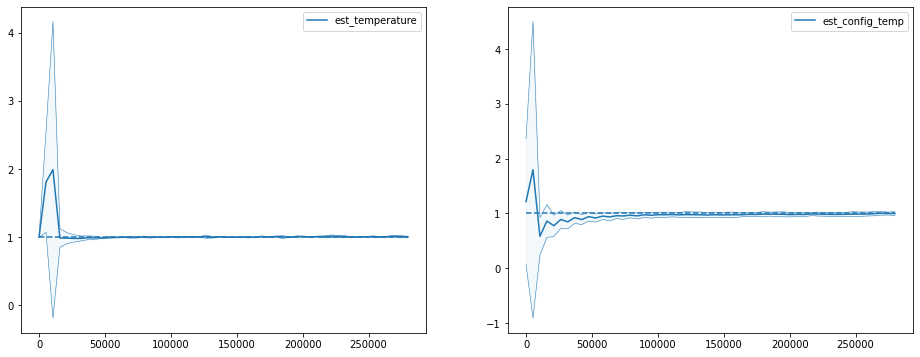

In [11]:
_, axes = plt.subplots(1, 2, figsize=(16, 6))

plot.temperature_stderr(axes[0], metrics, "est_temperature", sizes, ewma_alpha=0.0, mask=mask)
plot.temperature_stderr(axes[1], metrics, "est_config_temp", sizes, ewma_alpha=0.0, mask=mask)

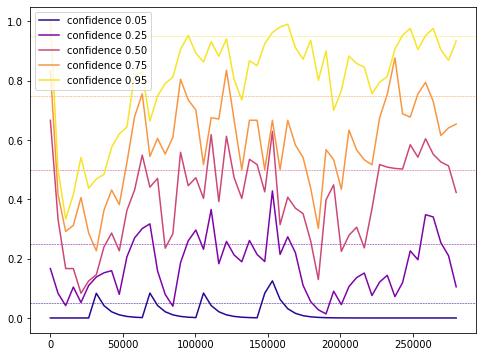

In [12]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))

plot.kinetic_temperature_intervals(ax, metrics, sizes, mask=mask, ewma_alpha=0.5)

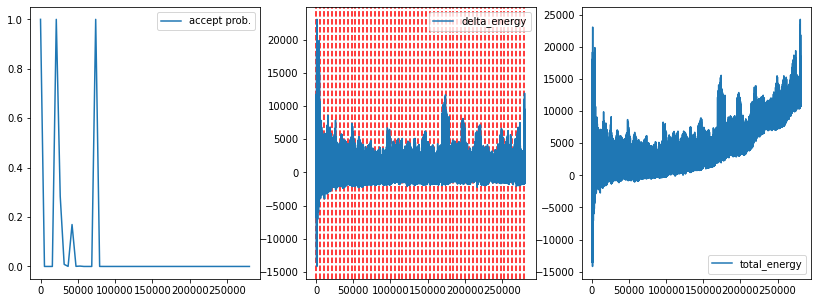

In [13]:
_, axes = plt.subplots(1, 3, figsize=(14, 5))

def accept_prob(x):
    return np.exp(np.minimum(0., -x))

plot.metric(axes[0], metrics, "delta_energy", transform=accept_prob,
            plot_kwargs=dict(label="accept prob."), mask=is_sample_mask)

plot.metric(axes[1], metrics, "delta_energy", mask=slice(None))
plot.vlines(axes[1], metrics, is_sample_mask)

plot.metric(axes[2], metrics, "total_energy", mask=slice(None))

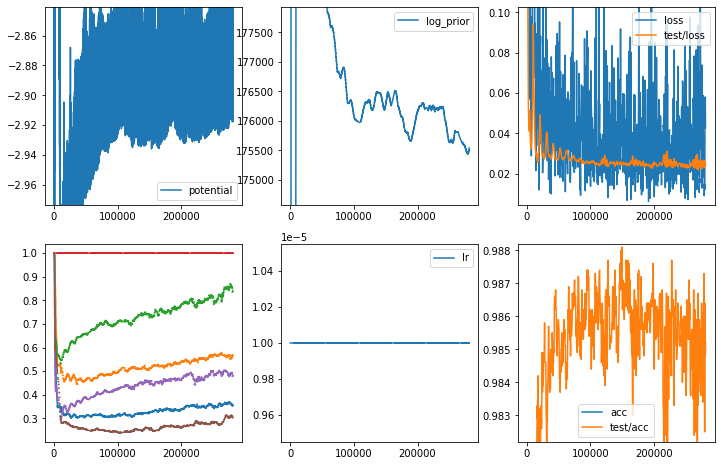

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

mask = slice(None)

plot.metric(axes[0, 0], metrics, 'potential', iqr_ylim=2., mask=mask)
plot.metric(axes[0, 1], metrics, 'log_prior', iqr_ylim=2., mask=mask)

test_mask = ~np.isnan(metrics["test/loss"])

plot.metric(axes[0, 2], metrics, 'loss', mask=slice(0, None, 40), iqr_ylim=2.)
plot.metric(axes[0, 2], metrics, 'test/loss', mask=test_mask)

for k in metrics["preconditioner"].keys():
    plot.metric(axes[1, 0], metrics, "preconditioner/"+k, mask=mask, legend=False)

plot.metric(axes[1, 1], metrics, 'lr')

plot.metric(axes[1, 2], metrics, 'acc', mask=mask, iqr_ylim=2., ewma_alpha=0.9)
plot.metric(axes[1, 2], metrics, 'test/acc', mask=test_mask, iqr_ylim=2.)

In [22]:
"average acceptance", 1-np.mean(metrics["acceptance/rejected"][mask])

('average acceptance', 9.205990704103418e+18)

In [16]:
config

{'batch_size': 125,
 'batchnorm': True,
 'bias_loc': 0.0,
 'bias_prior': 'gaussian',
 'bias_prior_params': {},
 'bias_scale': 1.0,
 'burnin': 0,
 'cycles': 80,
 'data': 'mnist',
 'depth': 3,
 'device': 'try_cuda',
 'inference': 'HMCReject',
 'init_method': 'he',
 'load_samples': None,
 'log_dir': 'logs/mnist_v3',
 'lr': 1e-05,
 'metrics_skip': 10,
 'model': 'correlatedclassificationconvnet',
 'momentum': 1.0,
 'n_samples': 80,
 'precond_update': 1,
 'progressbar': True,
 'reject_samples': False,
 'run_id': '4c850cfcfb1b4321a8ff411e56009f98',
 'sampling_decay': 'flat',
 'save_samples': True,
 'seed': 192127488,
 'skip': 1,
 'temperature': 1.0,
 'warmup': 10,
 'weight_loc': 0.0,
 'weight_prior': 'gaussian',
 'weight_prior_params': {},
 'weight_scale': 1.41,
 'width': 100}

In [17]:
mcmc_burnin = 0

state_dict_samples = exp_utils.load_samples(log_dir/"samples.pt", idx=np.s_[mcmc_burnin:])
if config["reject_samples"]:
    # Making sure that rejected samples have the same value as the previous one
    print("made sure of rejected samples")
    exp_utils.reject_samples_(state_dict_samples, metrics)


## Load and poke the model

In [19]:
del state_dict_samples["steps"]
del state_dict_samples["timestamps"]

if device == torch.device("cpu") and config["device"] != "cpu":
    # HACK: get around the lack of `nn.DataParallel` when loading on CPU:
    # *remove* .module. from the key
    for k in list(state_dict_samples.keys()):
        if k.startswith("net.module."):
            state_dict_samples["net." + k.lstrip("net.module.")] = state_dict_samples[k]
            del state_dict_samples[k]

In [20]:
model.load_state_dict({k: v[-1] for k, v in state_dict_samples.items()})

<All keys matched successfully>